(mmm_components)=
# Custom Models with MMM components

The underlying functionality of the `MMM` class allow for lots of flexibility. 

With a little knowledge of `PyMC`, there is a lot of flexibility to create different models 

In [1]:
from functools import partial

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc_marketing import mmm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed = sum(map(ord, "PyMC-Marketing provides flexible model components"))
rng = np.random.default_rng(seed)

draw = partial(pm.draw, random_seed=rng)

## Media Transformations

There are classes for each of the adstock and saturation transformations. They can be imported from the `pymc_marketing.mmm` module.

Each of the transformation will have a set of default priors

In [3]:
saturation = mmm.MichaelisMentenSaturation()
saturation.function_priors

{'alpha': {'dist': 'Gamma', 'kwargs': {'mu': 2, 'sigma': 1}},
 'lam': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}}}

### Sampling Transformation Function

Each transformation provides some methods to better understand the transformation.

For instance, the `sample_prior` method can be used to sample the parameters of the functions.

**NOTE:** There is the prefix `saturation_` on each of the parameters in order to not clash with the larger model

In [5]:
prior = saturation.sample_prior(random_seed=rng)
prior

Sampling: [saturation_alpha, saturation_lam]


<xarray.Dataset> Size: 12kB
Dimensions:           (chain: 1, draw: 500)
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Data variables:
    saturation_alpha  (chain, draw) float64 4kB 2.114 0.8256 ... 2.056 2.347
    saturation_lam    (chain, draw) float64 4kB 0.7597 0.09256 ... 0.8022 0.8724
Attributes:
    created_at:                 2024-06-15T05:35:54.169190
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.14.0

With some parameters for the function, the curve can be sampled as well. Combining `sample_curve` and `plot_curve` together can provide good insight into the shape the curve makes!

Sampling: []


Output()

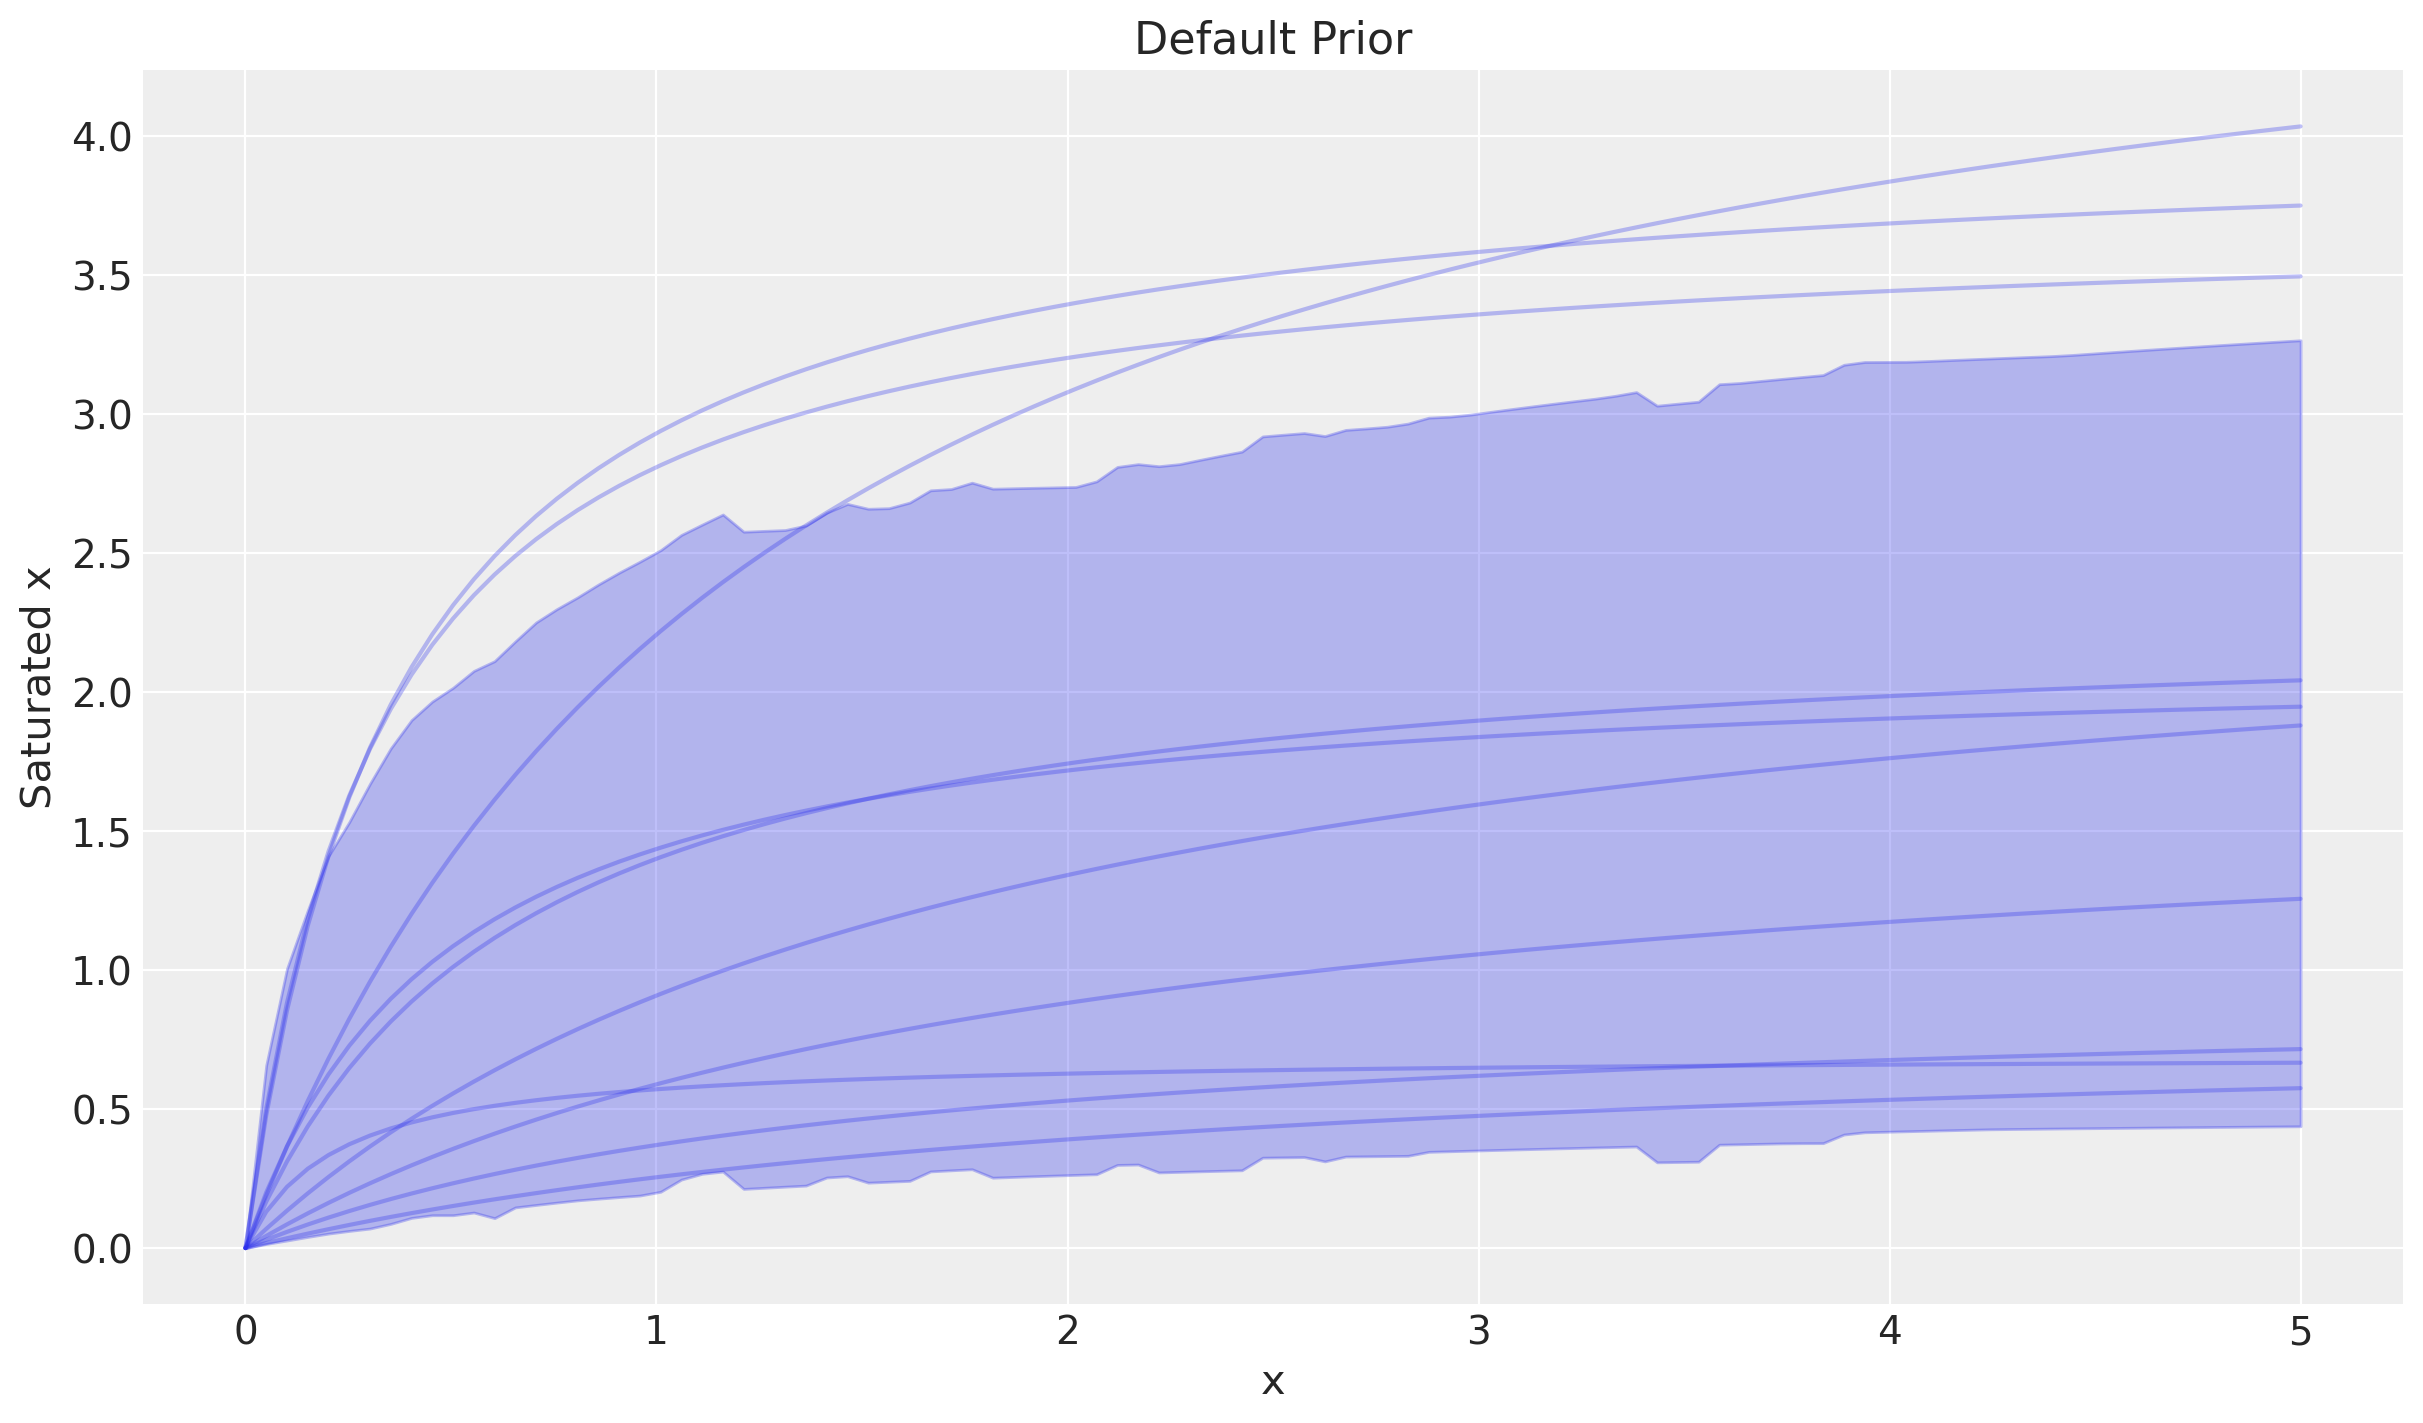

In [5]:
curve = saturation.sample_curve(prior, max_value=5)
_, axes = saturation.plot_curve(curve)
axes[0].set(
    ylabel="Saturated x",
    title="Default Prior",
);

### Adding Parameter Dimensions

In most cases, a separate saturation function will want to be estimated for each media channel.

In [63]:
def random_spends(coords) -> xr.DataArray:
    size = tuple([len(values) for values in coords.values()])
    dims = list(coords.keys())

    spends_rv = pm.HalfNormal.dist(size=size)

    return xr.DataArray(
        draw(spends_rv),
        coords=coords,
        dims=dims,
        name="spends",
    )

For this example, we will have 2 years of media spend for 3 channels

In [26]:
n_dates = 52 * 2
dates = pd.date_range("2023-01-01", periods=n_dates, freq="W-MON")

channels = ["C1", "C2", "C3"]

coords = {
    "date": dates,
    "channel": channels,
}

In [27]:
df_spends = random_spends(coords=coords).to_pandas()
df_spends.head()

channel,C1,C2,C3
date,,,
2023-01-02,0.597112,0.377009,0.494004
2023-01-09,0.741815,0.167830,0.603458
2023-01-16,1.746970,0.516513,1.743357
2023-01-23,0.971506,1.833023,1.236266
2023-01-30,0.915950,0.100394,0.256572


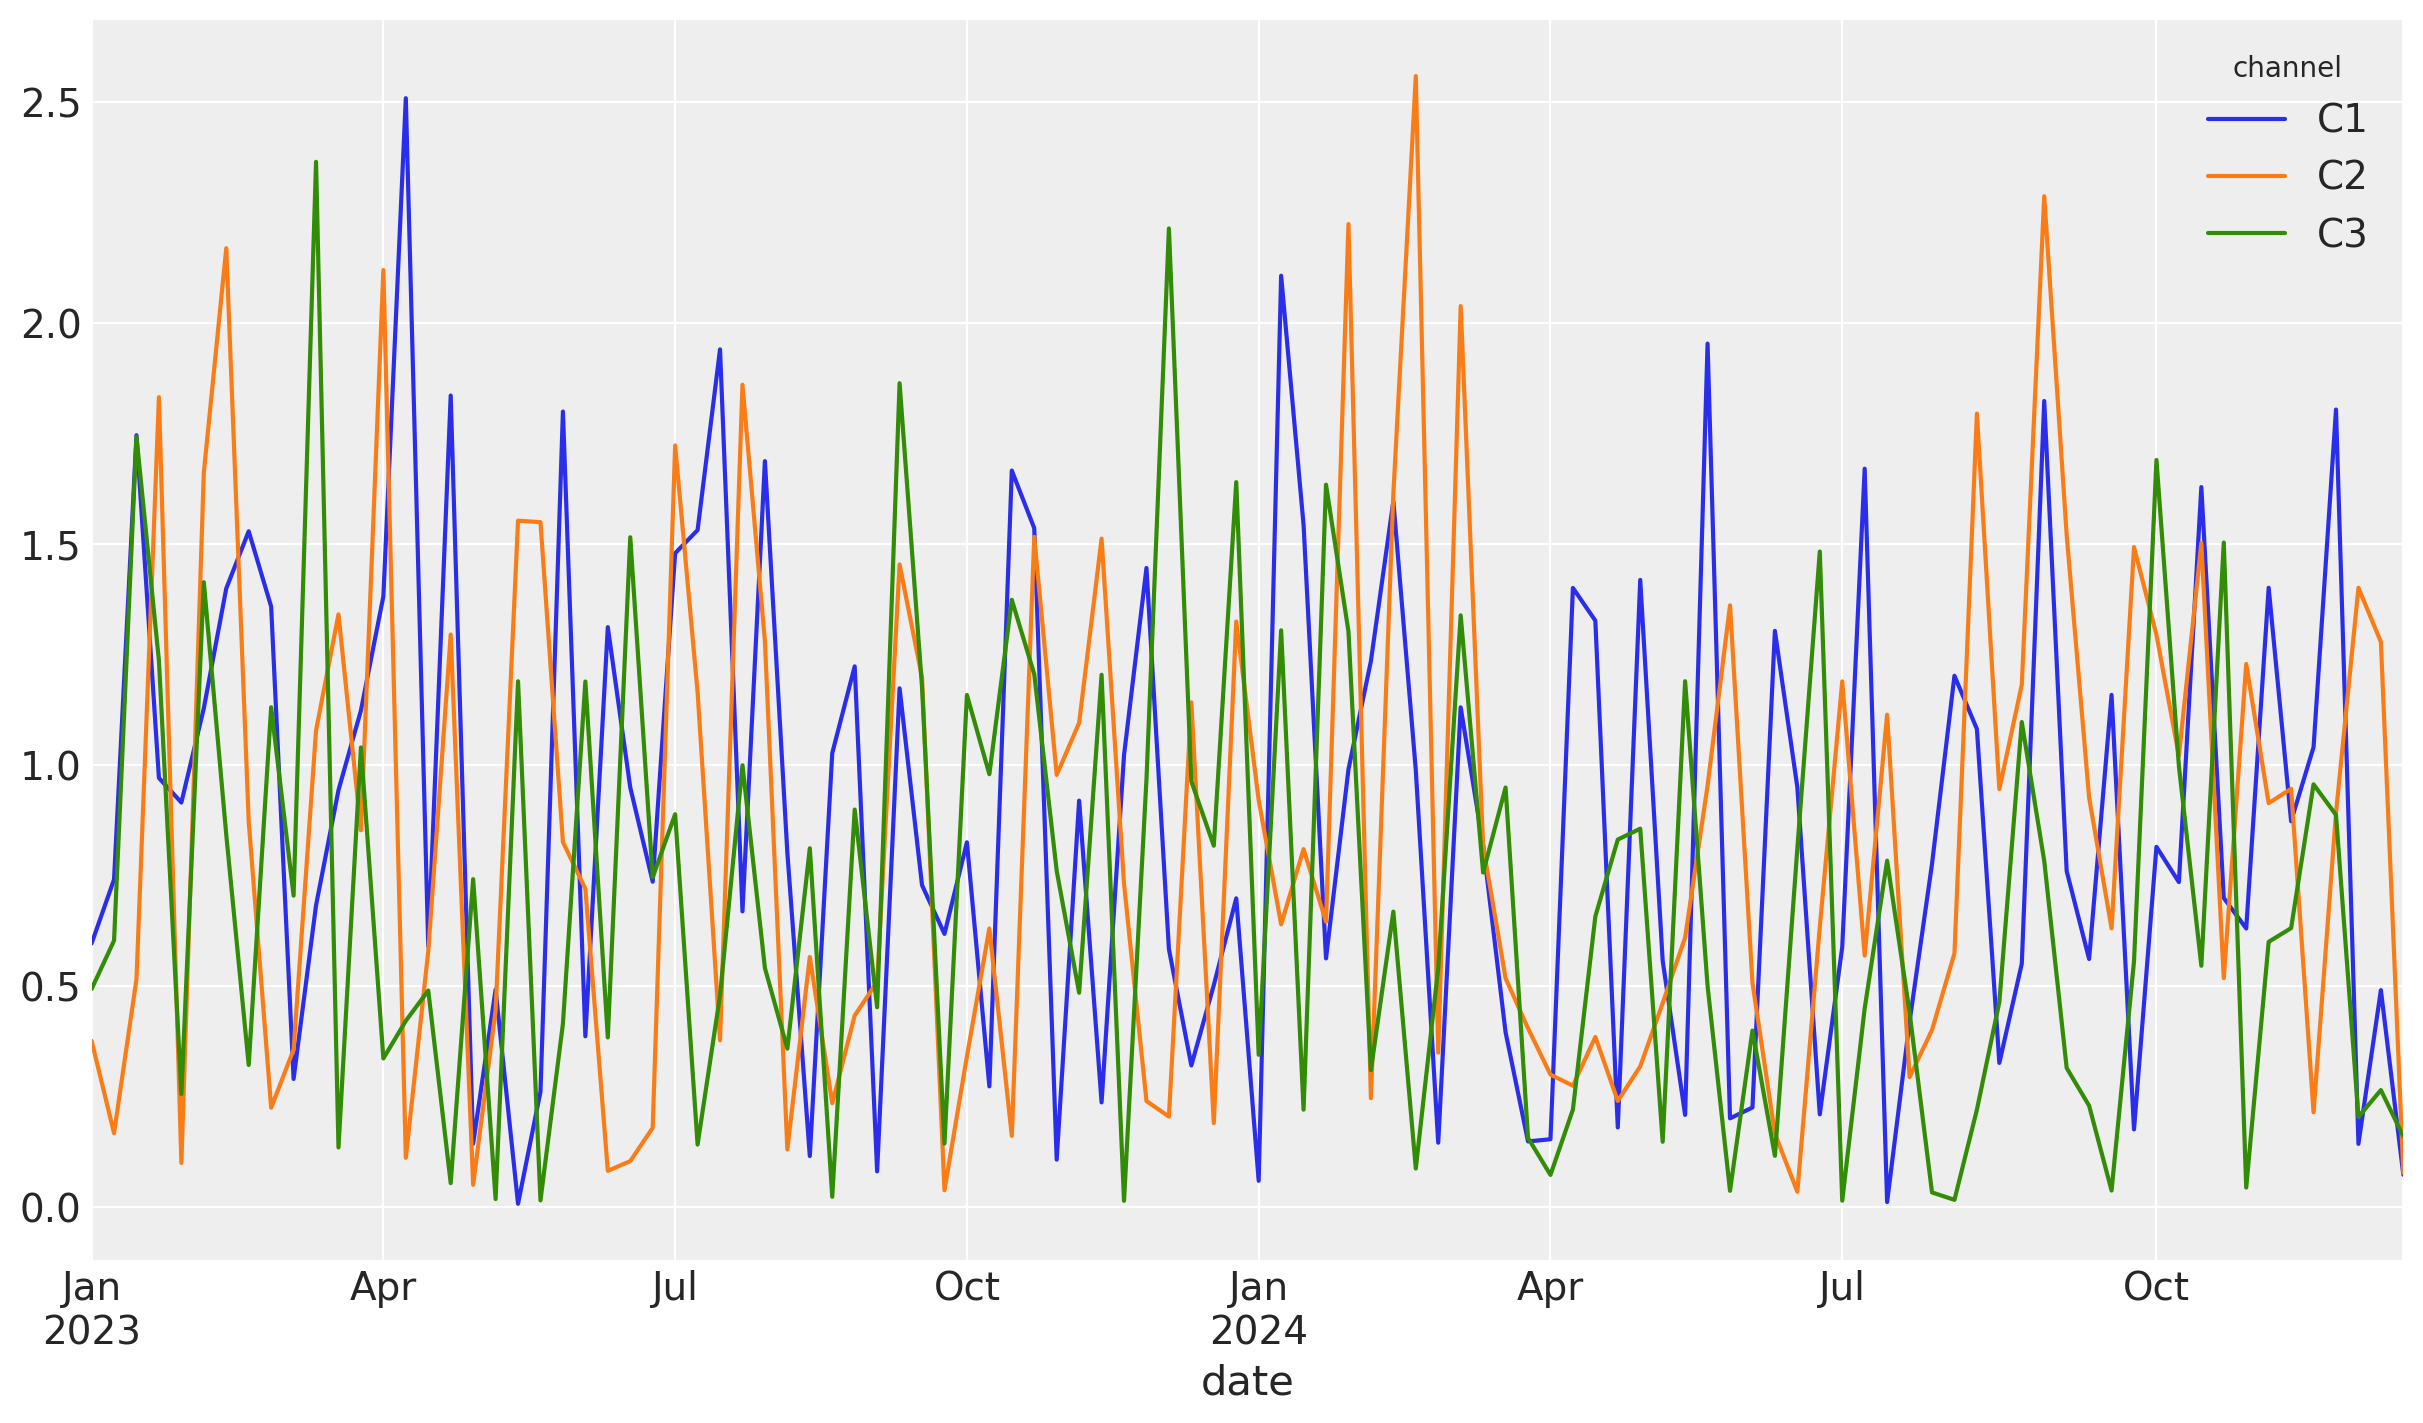

In [29]:
df_spends.plot();

Note above that the default priors do not have a channel dimension. In order to use with the in our model with "channel" dim, we have to add the dims to each of the function priors

In [31]:
for config in saturation.function_priors.values():
    config["dims"] = "channel"

saturation.function_priors

{'alpha': {'dist': 'Gamma',
  'kwargs': {'mu': 2, 'sigma': 1},
  'dims': 'channel'},
 'lam': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}, 'dims': 'channel'}}

The previous workflow can be used to understand our priors still. Just pass the `coords` to the `sample_prior` method in order to add dims to the appropriate variables.

In [36]:
prior = saturation.sample_prior(coords=coords, random_seed=rng)
prior

Sampling: [saturation_alpha, saturation_lam]


<xarray.Dataset> Size: 28kB
Dimensions:           (chain: 1, draw: 500, channel: 3)
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * channel           (channel) <U2 24B 'C1' 'C2' 'C3'
Data variables:
    saturation_alpha  (chain, draw, channel) float64 12kB 1.409 1.793 ... 2.196
    saturation_lam    (chain, draw, channel) float64 12kB 0.1121 ... 0.07197
Attributes:
    created_at:                 2024-06-15T05:47:22.129025
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.14.0

Sampling: []


Output()

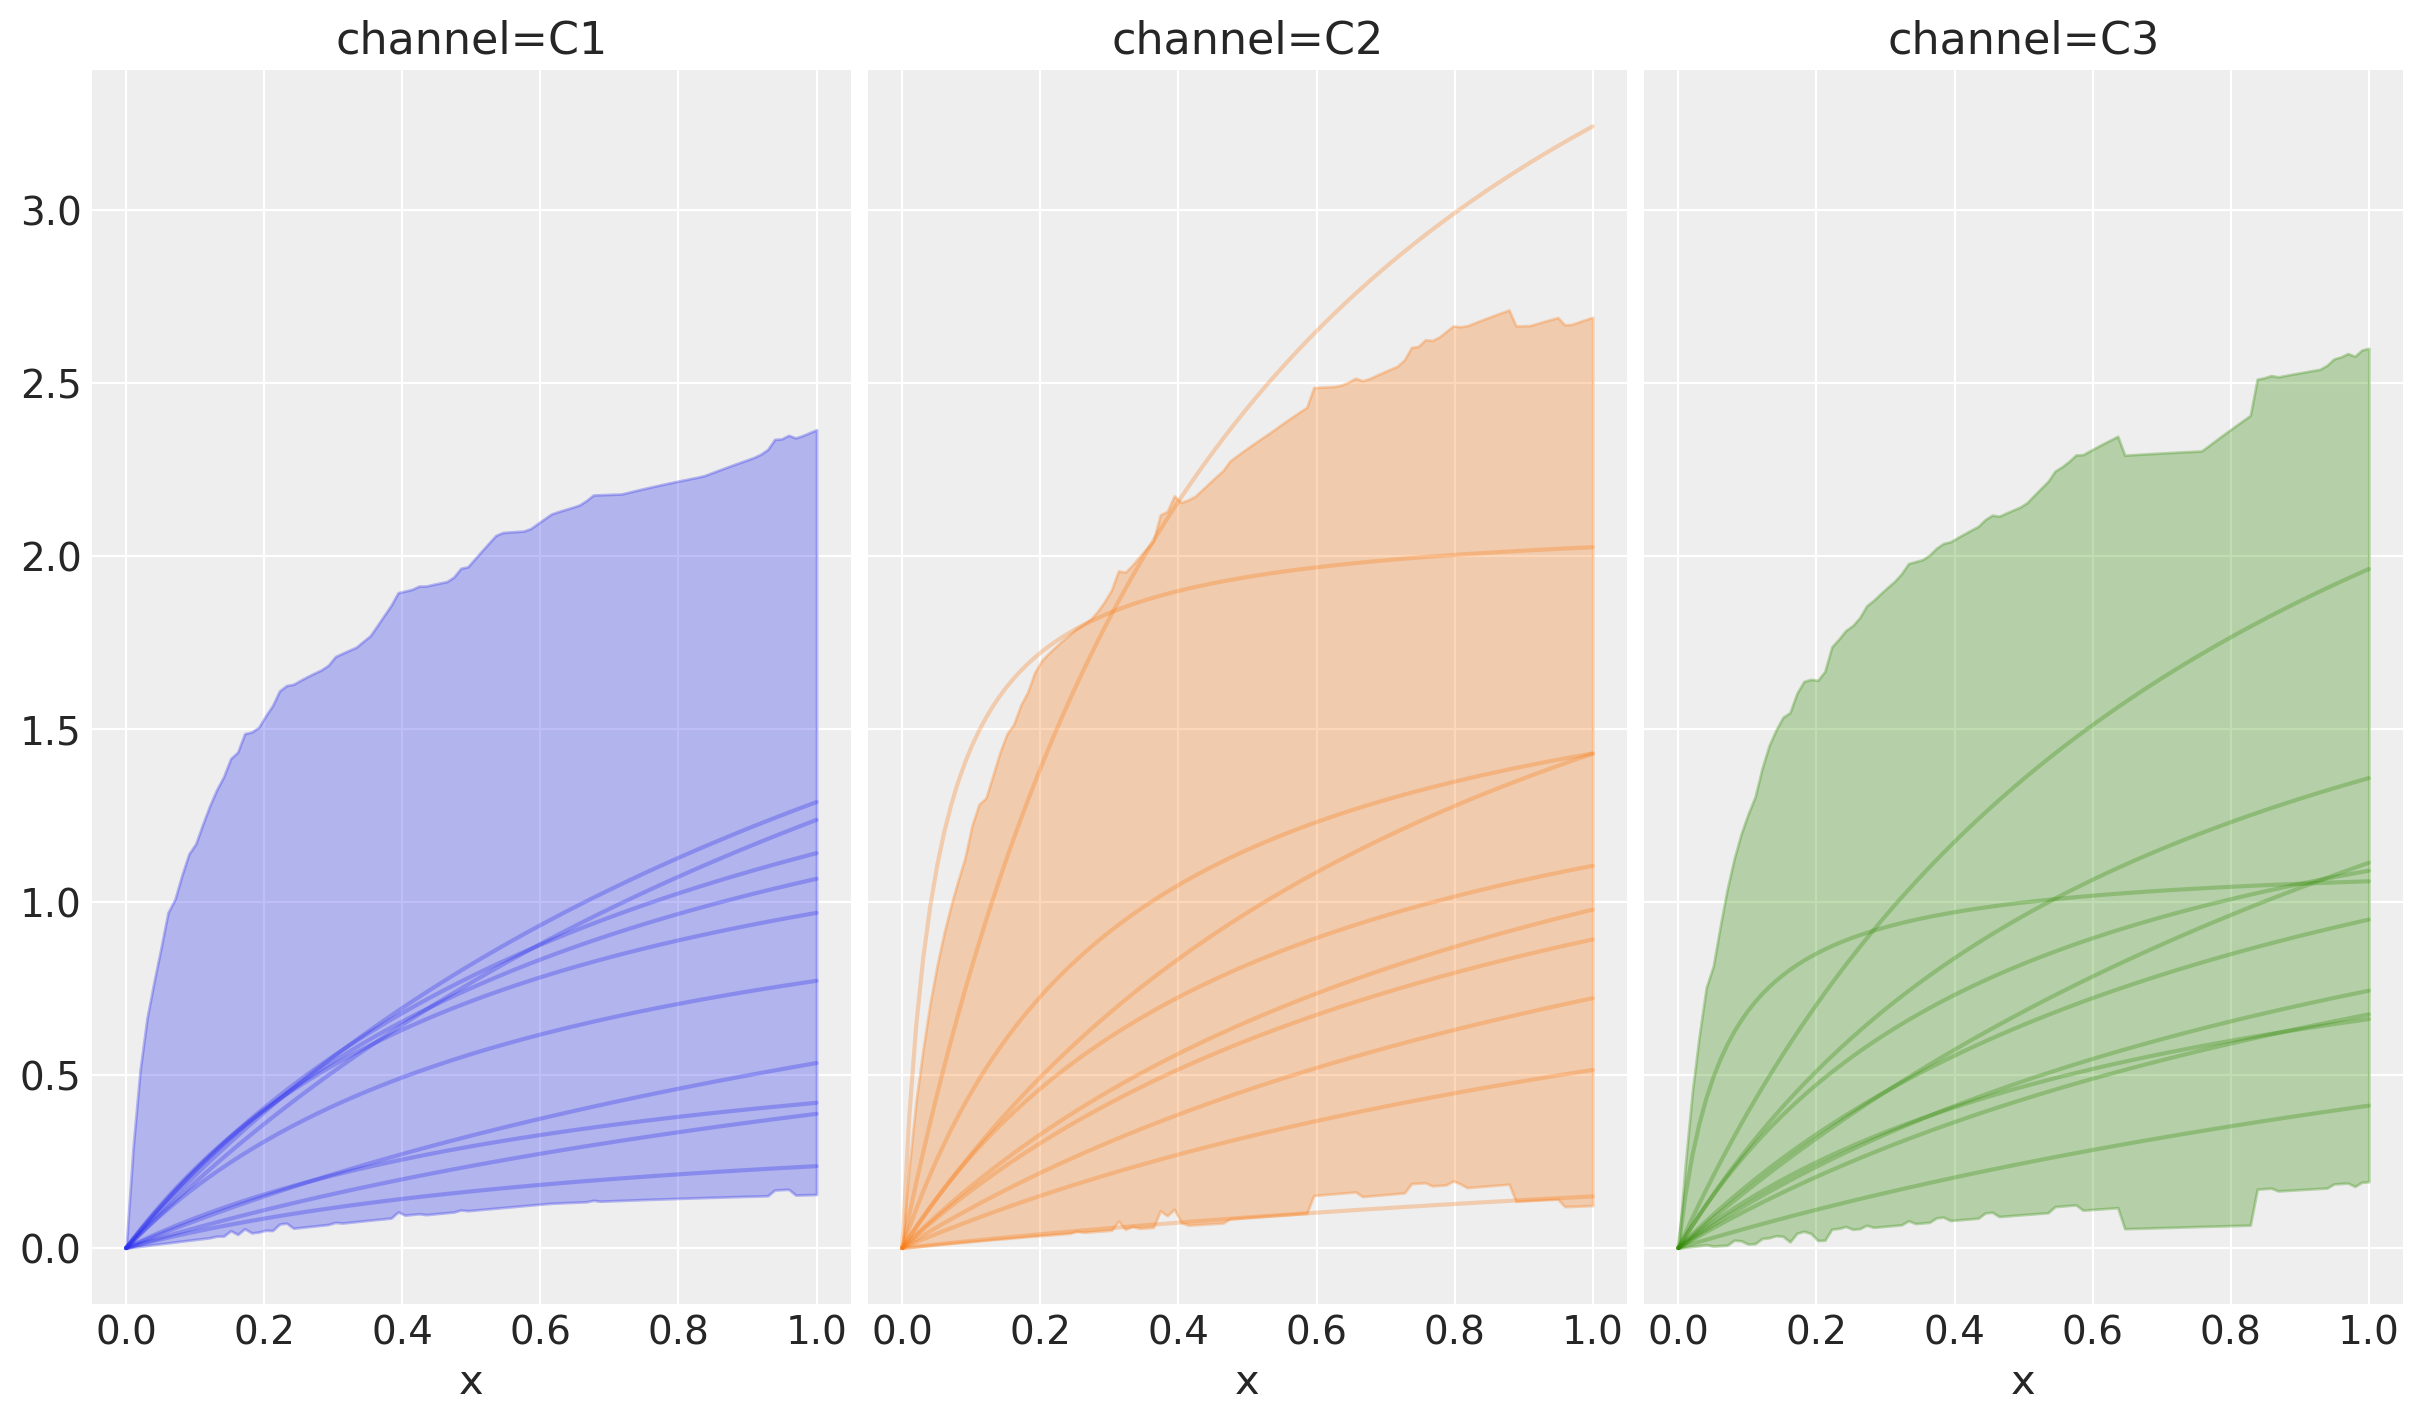

In [35]:
curve = saturation.sample_curve(prior)
saturation.plot_curve(curve, subplot_kwargs={"sharey": True});

### Using in PyMC Model

The transformations have an `apply` method which will: 

- create distributions based on prior specification
- apply the transformation to the data

The method can be used in arbitrary `PyMC` models:

In [38]:
with pm.Model(coords=coords) as model:
    saturated_spends = saturation.apply(df_spends, dims="channel")

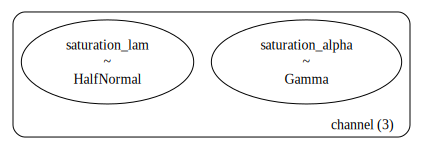

In [39]:
pm.model_to_graphviz(model)

**NOTE:** Neither the `df_spends` nor `saturated_spends` show in the model. If needed, use `pm.Data` and `pm.Deterministic` to save off.

Our variable will be (date, channel) dims.

In [43]:
saturated_spends.type.shape

(104, 3)

### Changing Assumptions

As hinted above, the priors for the function parameters are customizable which can lead to many different models.

The distributions just need to follow the distribution API [here](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.model_config.html).

Instead of the defaults, we can use:
- hierarchical parameter for `lam` parameter
- common `alpha` parameter
  

In [44]:
alpha_distribution =  {
    "dist": "HalfNormal",
    "kwargs": {
        "sigma": {
            "dist": "HalfNormal",
            "kwargs": {"sigma": 1},
        }
    },
    "dims": "channel",
}
priors = {
    "lam": alpha_distribution,
}

saturation = mmm.MichaelisMentenSaturation(priors=priors)

saturation.function_priors

{'alpha': {'dist': 'Gamma', 'kwargs': {'mu': 2, 'sigma': 1}},
 'lam': {'dist': 'HalfNormal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}}},
  'dims': 'channel'}}

Then this can be used in a new `PyMC` model!

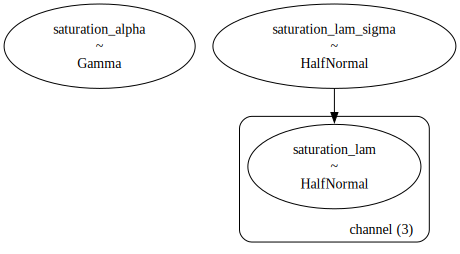

In [46]:
with pm.Model(coords=coords) as model:
    saturated_spends = saturation.apply(df_spends, dims="channel")

pm.model_to_graphviz(model)

The previous workflow still helps us understand the produced curves

In [48]:
prior = saturation.sample_prior(coords=coords, random_seed=rng)

Sampling: [saturation_alpha, saturation_lam, saturation_lam_sigma]


Sampling: [saturation_lam, saturation_lam_sigma]


Output()

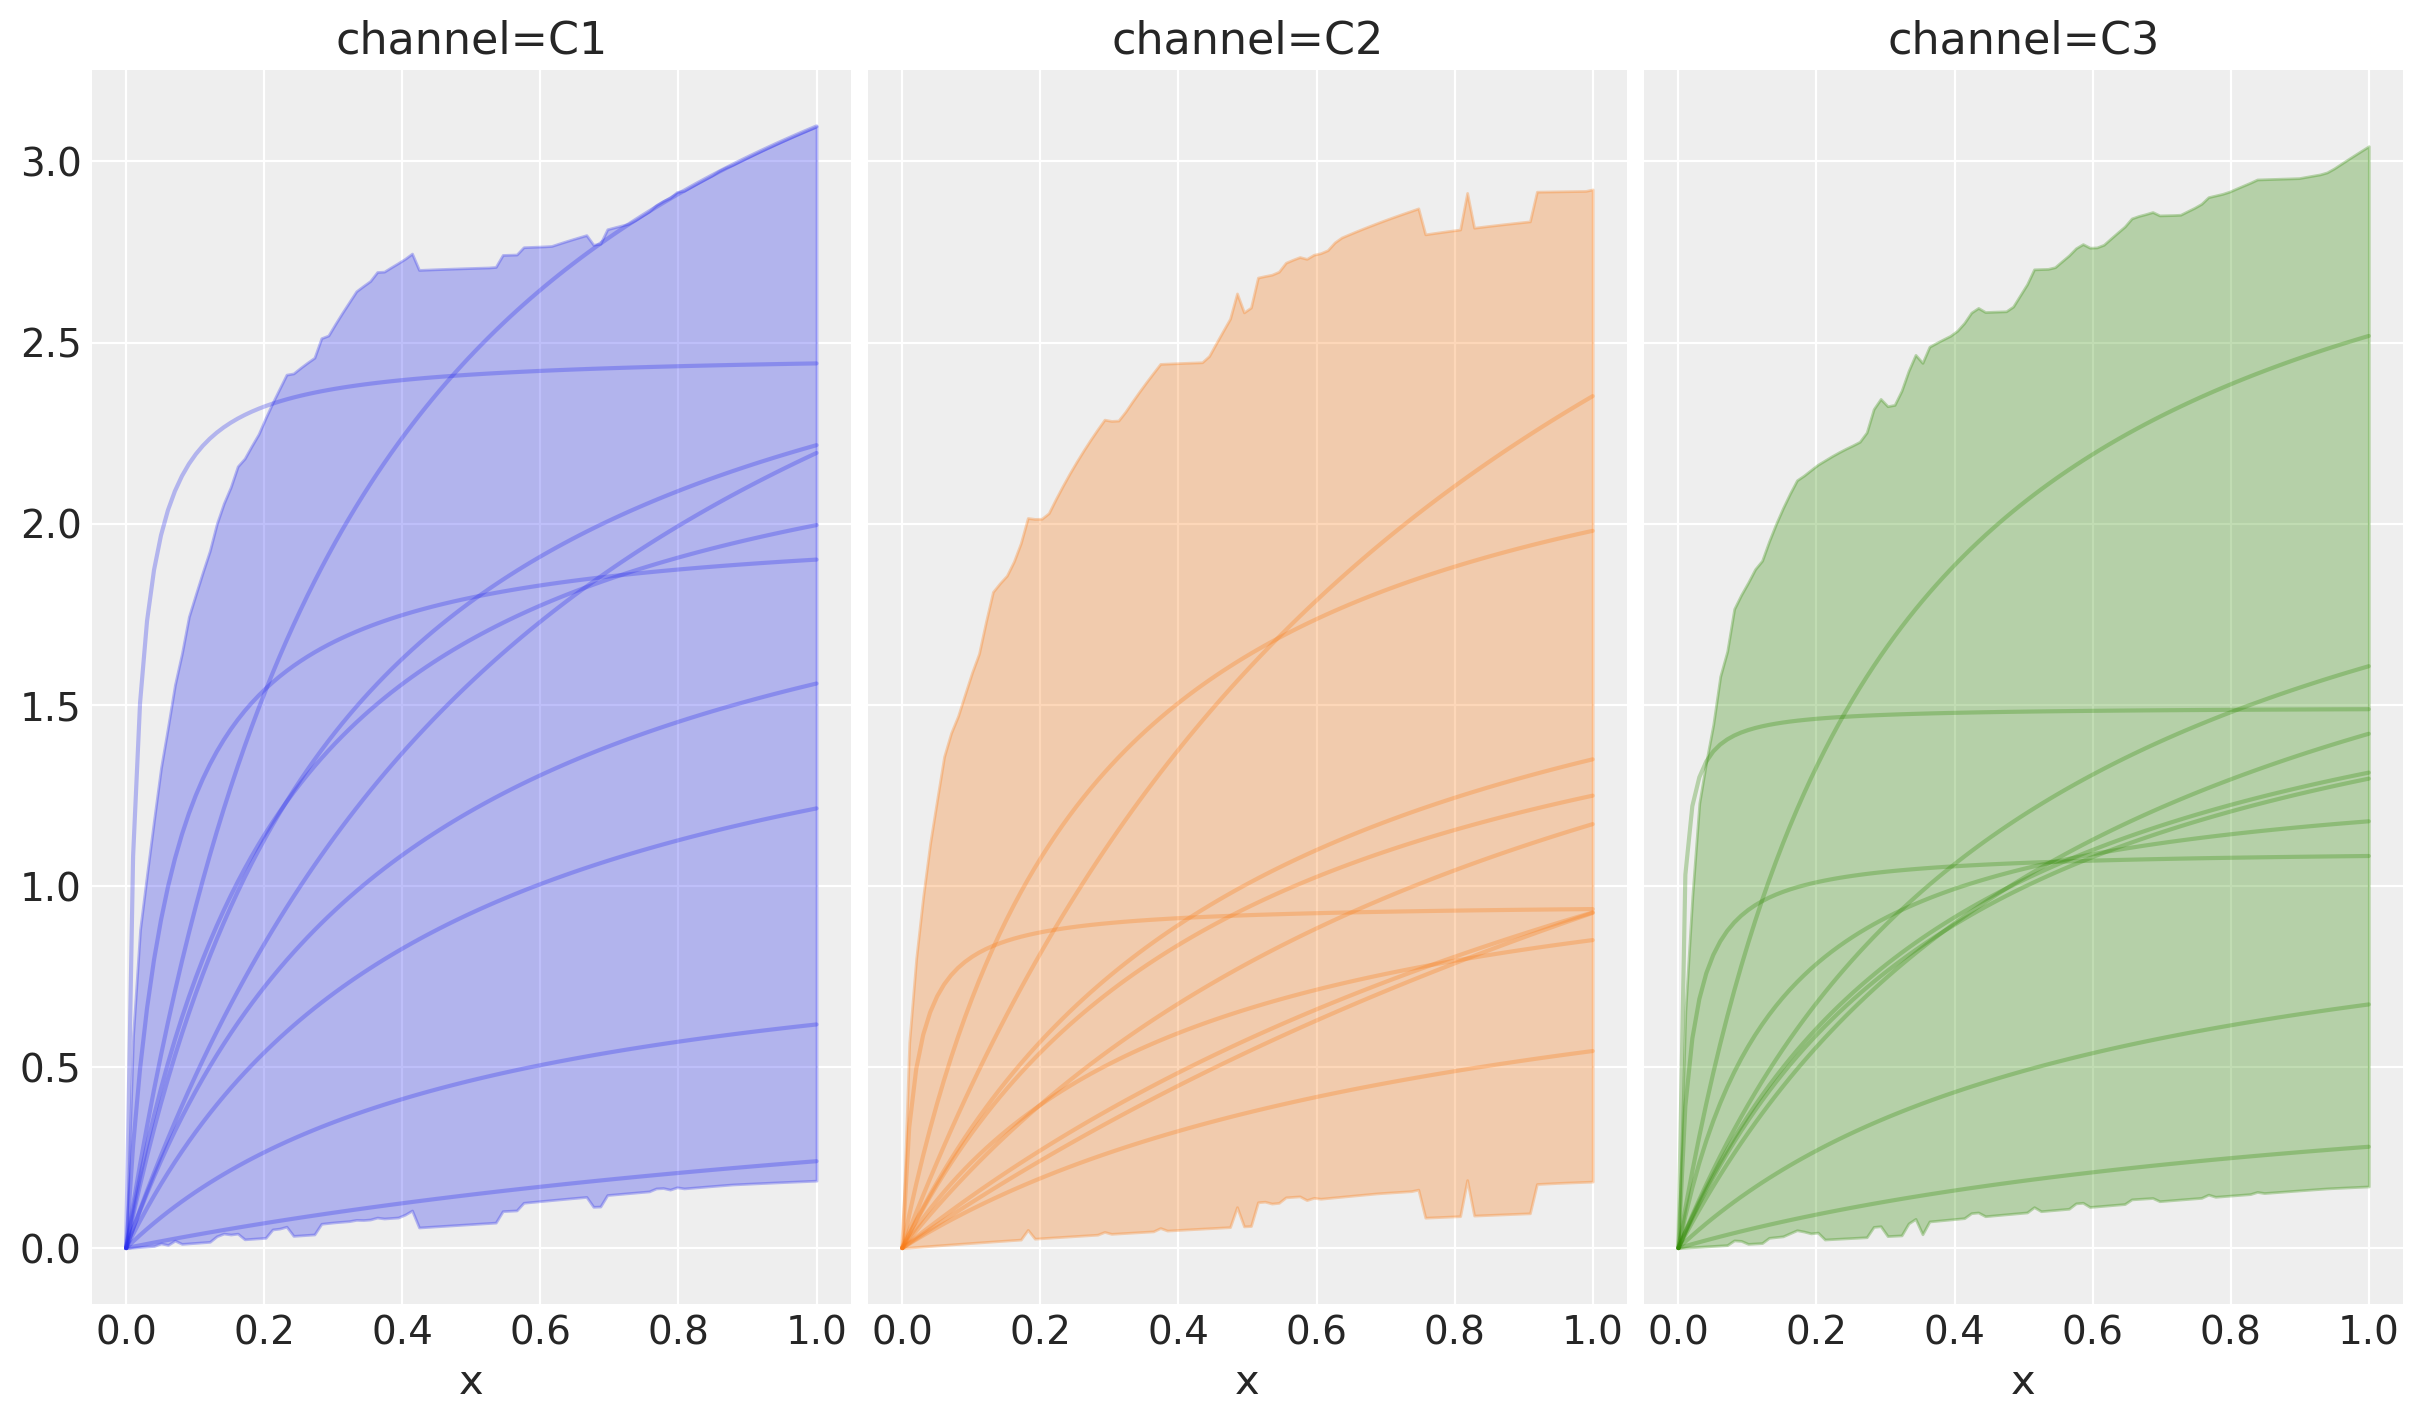

In [49]:
curve = saturation.sample_curve(prior)
saturation.plot_curve(curve, subplot_kwargs={"sharey": True});

#### Geo Hierarchical Model

The dimensions of the parameters are not limited to 1D so additional hierarchies can be defined

In [53]:
mmm.MichaelisMentenSaturation.default_priors

{'alpha': {'dist': 'Gamma', 'kwargs': {'mu': 2, 'sigma': 1}},
 'lam': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}}}

In [101]:
priors = {
    "alpha": {
        "dist": "Gamma",
        "kwargs": {
            "mu": {"dist": "HalfNormal", "kwargs": {"sigma": 1}, "dims": "geo"},
            "sigma": {"dist": "HalfNormal", "kwargs": {"sigma": 1}, "dims": "geo"},
        },
        "dims": ("channel", "geo")
    },
    "lam": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 1},
        "dims": "channel",
    },
}
saturation = mmm.MichaelisMentenSaturation(priors=priors)

In [103]:
geo_coords = {
    **coords,
    "geo": ["Region1", "Region2", "Region3"],
}

geo_spends = random_spends(coords=geo_coords)

In [104]:
geo_spends.to_series().unstack().head(6)

geo                  Region1   Region2   Region3
date       channel                              
2023-01-02 C1       0.344419  0.044645  0.269671
           C2       0.097112  0.045217  0.490039
           C3       0.376060  0.489937  0.417361
2023-01-09 C1       0.222072  2.689753  0.262887
           C2       0.040015  0.216940  1.429200
           C3       1.928993  1.002213  1.918579

In [105]:
with pm.Model(coords=geo_coords) as geo_model:
    geo_data = pm.Data(
        "geo_data",
        geo_spends.to_numpy(),
        dims=("date", "channel", "geo"),
    )
    saturated_geo_spends = pm.Deterministic(
        "saturated_geo_spends",
        saturation.apply(geo_data, dims=("channel", "geo")),
        dims=("date", "channel", "geo"),
    )

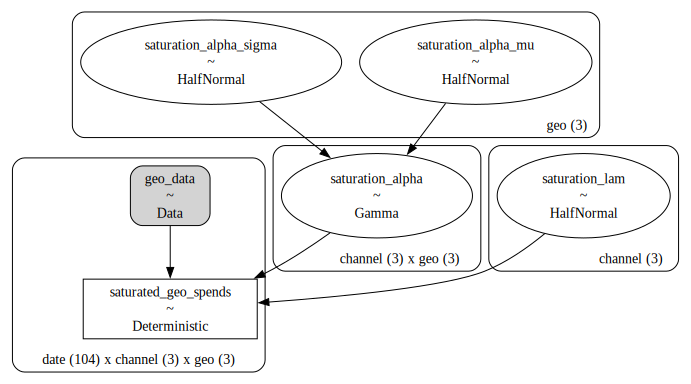

In [106]:
pm.model_to_graphviz(geo_model)

## All together

Lots of flexibility by combining them together

In [107]:
def create_media_transformation(adstock, saturation, adstock_first: bool = True):
    first, second = (
        (adstock, saturation)
        if adstock_first
        else (saturation, adstock)
    )

    def media_transformation(x, dims):
        return second.apply(first.apply(x, dims=dims), dims=dims)
    return media_transformation

In [108]:
mmm.GeometricAdstock.default_priors

{'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}}}

In [109]:
priors = {
    "alpha": {
        "dist": "Beta",
        "kwargs": {
            "alpha": {"dist": "HalfNormal", "kwargs": {"sigma": 1}, "dims": "channel"},
            "beta": {"dist": "HalfNormal", "kwargs": {"sigma": 1}, "dims": "channel"},
        },
        "dims": ("channel", "geo"),
    },
}
adstock = mmm.GeometricAdstock(l_max=10, priors=priors)

In [110]:
media_transformation = create_media_transformation(adstock, saturation, adstock_first=True)

with pm.Model(coords=geo_coords) as geo_model:
    geo_data = pm.Data(
        "geo_data",
        geo_spends.to_numpy(),
        dims=("date", "channel", "geo"),
    )
    saturated_geo_spends = pm.Deterministic(
        "channel_contributions",
        media_transformation(geo_data, dims=("channel", "geo")),
        dims=("date", "channel", "geo"),
    )

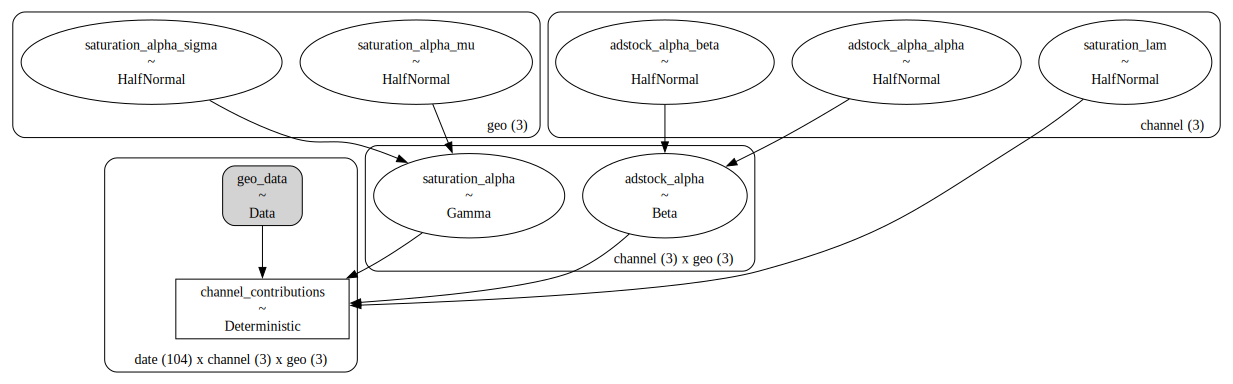

In [111]:
pm.model_to_graphviz(geo_model)

## Summary

Custom models are possible

Highlight what we get from using our prebuilt components